In [1]:
import os, itertools, time
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16, 'figure.figsize': (40, 8), 'font.family': 'serif', 'text.usetex': True, 'pgf.rcfonts': False})

%load_ext autoreload
%autoreload 2

import jax
jax.config.update('jax_platform_name', 'cpu')

import indices, points
import smolyak_jax as sj

def target_f(x, theta, r) :
    return 1/(1+ theta * np.sum(x * (np.arange(x.shape[-1]) + 2)**(-r), axis=-1))

In [2]:
r, theta = 2., .1
dimensions = [10,1000]
batchsize = 250
n_max = 10000
n_tests = 10

f = lambda x : target_f(x, theta, r)

cost_setup = np.zeros((len(dimensions), n_tests))
cost_eval = np.zeros((len(dimensions), n_tests))
ns = np.zeros((len(dimensions), n_tests))

for i, d in enumerate(dimensions) :
    g = points.LejaMulti(d=d)
    k  = [np.log((ki+2)**(r)/theta) for ki in range(d)]
    max_l = indices.find_suitable_l(k, n_max, g.is_nested)
    for j, l in enumerate(np.linspace(1,max_l,n_tests)) : 
        # measure setup time
        t = time.time()
        ip = sj.MultivariateSmolyakBarycentricInterpolator(g=g, k=k, l=l, rank=1, f=f, batchsize=batchsize)
        cost_setup[i,j] = time.time() - t
        ns[i,j] = ip.n

        # measure eval time
        x = g.get_random(batchsize)
        t = time.time()
        y = ip(x)
        cost_eval[i,j] = time.time() - t

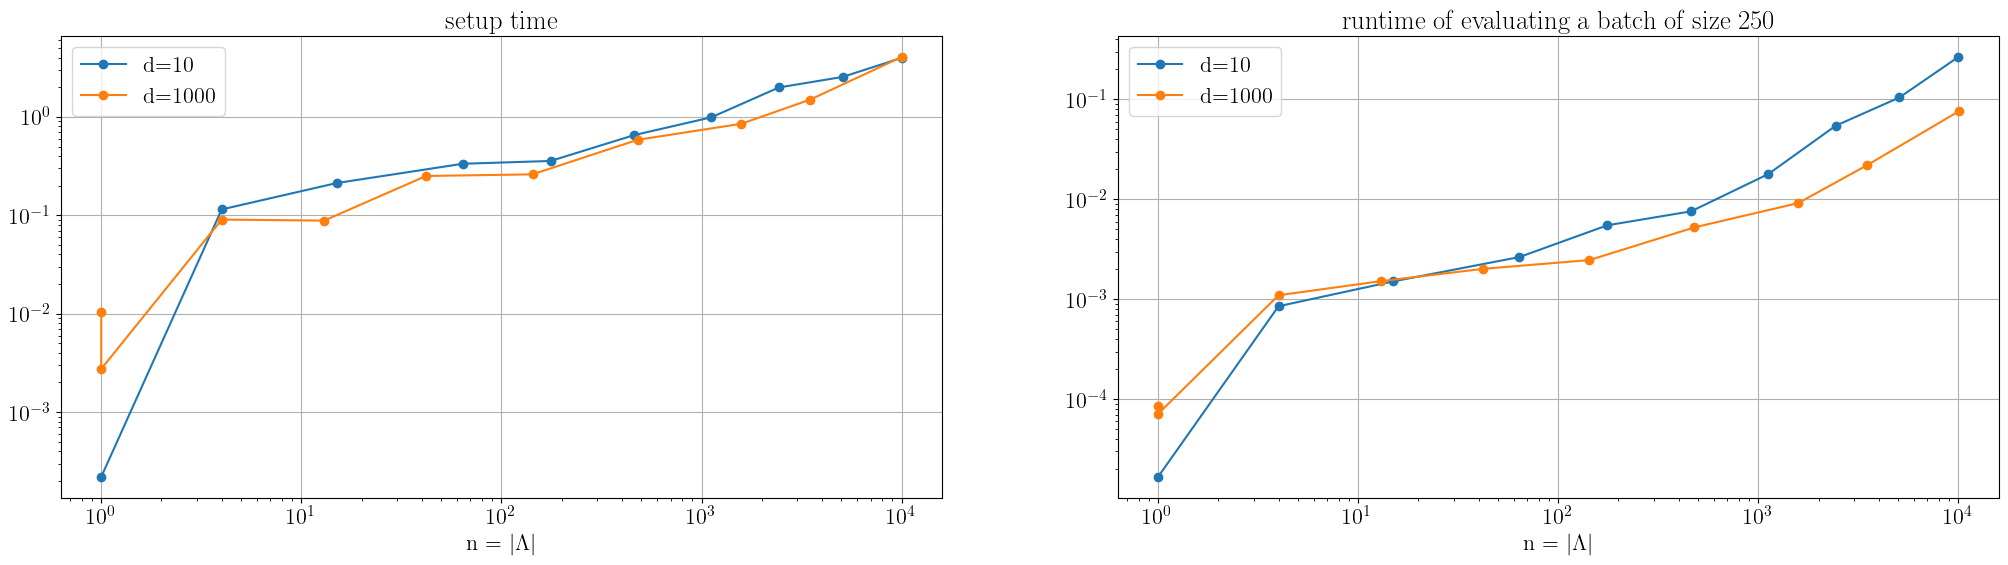

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(25,6))

for i, d in enumerate(dimensions) :
    axes[0].loglog(ns[i], cost_setup[i], marker='o', label=rf'd={d}')
    axes[1].loglog(ns[i], cost_eval[i], marker='o', label=rf'd={d}')

for ax, title in zip(axes, [rf'setup time', rf'runtime of evaluating a batch of size {batchsize}']) :
    ax.set_xlabel(r'n = $|\Lambda|$'); ax.grid(); ax.legend(); ax.set_title(title); 

In [4]:
r, theta = 2., .1
d = 100
batchsizes = [1,10,100,1000]
n_max = 10000
n_tests = 8

f = lambda x : target_f(x, theta, r)
g = points.LejaMulti(d=d)
k  = [np.log((ki+2)**(r)/theta) for ki in range(d)]
max_l = indices.find_suitable_l(k, n_max, g.is_nested)

cost_eval = np.zeros((len(batchsizes), n_tests))
ns = np.zeros((len(batchsizes), n_tests))

for i, b in enumerate(batchsizes) :
    for j, l in enumerate(np.linspace(1,max_l,n_tests)) :
        ip = sj.MultivariateSmolyakBarycentricInterpolator(g=g, k=k, l=l, rank=1, f=f, batchsize=b)
        ns[i,j] = ip.n

        x = g.get_random(b)
        t = time.time()
        y = ip(x)
        cost_eval[i,j] = (time.time() - t) 

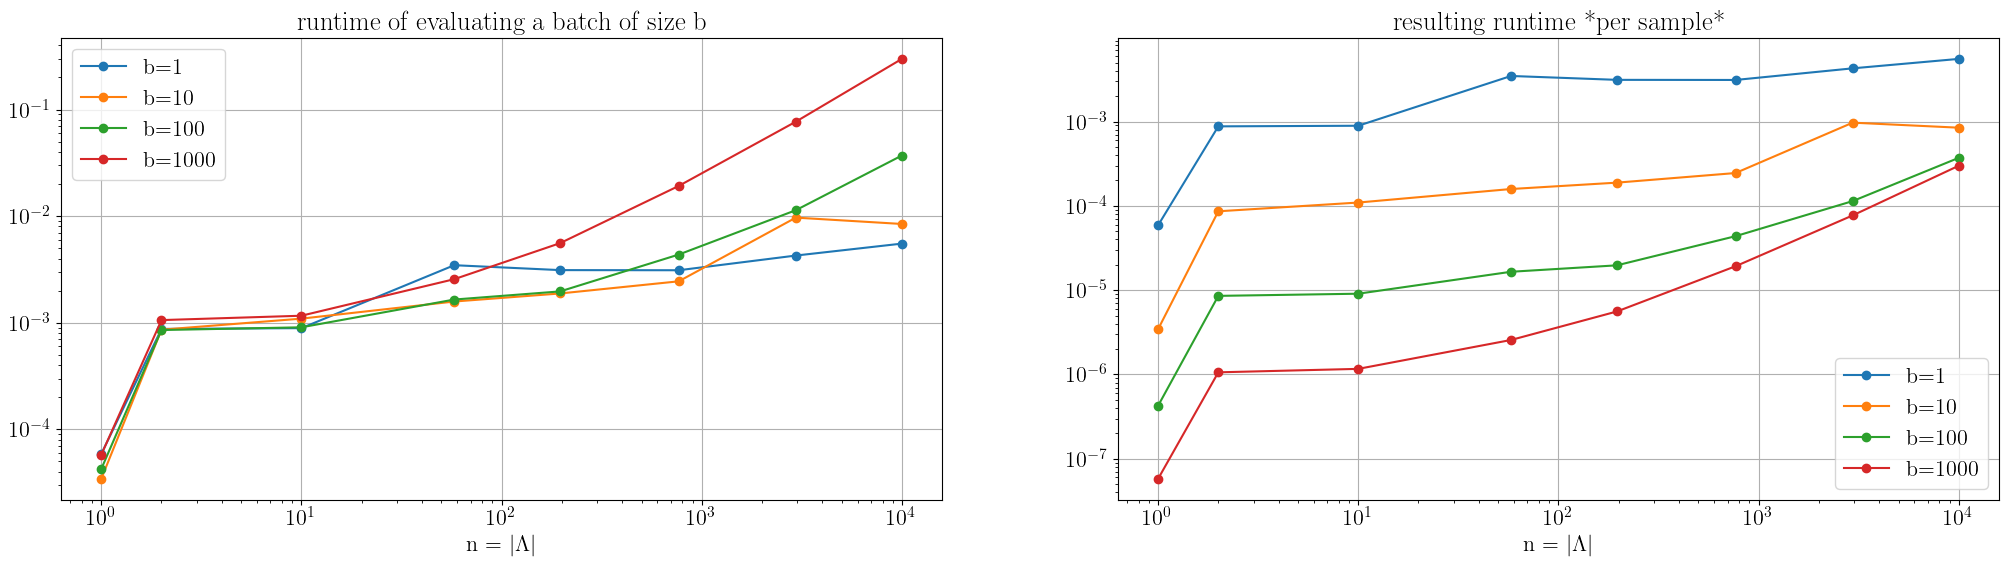

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(25,6))
for i, b in enumerate(batchsizes) :
    axes[0].loglog(ns[i], cost_eval[i], marker='o', label=rf'b={b}')
    axes[1].loglog(ns[i], cost_eval[i]/b, marker='o', label=rf'b={b}')
for ax, title in zip(axes, [rf'runtime of evaluating a batch of size b', rf'resulting runtime *per sample*']) : 
    ax.set_xlabel(r'n = $|\Lambda|$'); ax.grid(); ax.legend(); ax.set_title(title); 